ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
✅ Tokenizer already exists.


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,8.739200
100,7.503900
150,7.175700
200,7.082900
250,6.789200
300,6.714600
350,6.706700
400,6.511400
450,6.736900


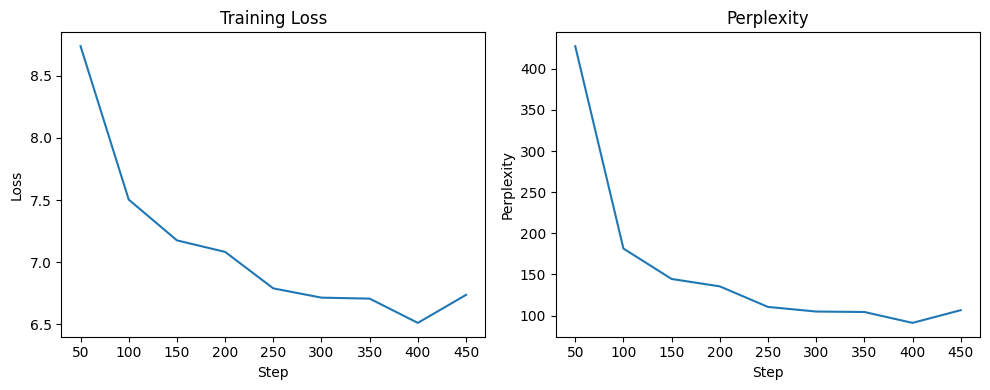


✅ Training complete. Run the functions below to download outputs:
- download_model_files()
- download_tokenizer_files()
- download_plot()


In [ ]:
!pip install -q transformers datasets tokenizers matplotlib accelerate fsspec==2025.3.0


import os
from pathlib import Path
from transformers import (
    GPT2TokenizerFast, GPT2Config, GPT2LMHeadModel,
    Trainer, TrainingArguments, TextDataset,
    DataCollatorForLanguageModeling
)
from tokenizers import ByteLevelBPETokenizer
import matplotlib.pyplot as plt

#Train Tokenizer
dataset_path = "usa_edu_corpus_cleaned.txt"
tokenizer_dir = "custom_tokenizer"

if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    print("🔤 Training custom BPE tokenizer...")
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(
        files=dataset_path,
        vocab_size=50257,
        min_frequency=2,
        special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
    )
    tokenizer.save_model(tokenizer_dir)
else:
    print("Tokenizer already exists.")

tokenizer = GPT2TokenizerFast.from_pretrained(tokenizer_dir)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 uses eos as pad

#Load Dataset
def load_dataset(train_path, tokenizer, block_size=1024):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=train_path,
        block_size=block_size
    )

def get_data_collator(tokenizer):
    return DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

train_dataset = load_dataset(dataset_path, tokenizer)
data_collator = get_data_collator(tokenizer)

#GPT-2 Config
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=1024,
    n_ctx=1024,
    n_embd=768,
    n_layer=12,
    n_head=12,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

model = GPT2LMHeadModel(config)

#Training
output_dir = "gpt2_edu_model"
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

#Plot Loss & Perplexity
loss_history = trainer.state.log_history
steps = [x["step"] for x in loss_history if "loss" in x]
losses = [x["loss"] for x in loss_history if "loss" in x]
perplexities = [pow(2, l) for l in losses]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(steps, losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(steps, perplexities)
plt.title("Perplexity")
plt.xlabel("Step")
plt.ylabel("Perplexity")

plt.tight_layout()
plt.savefig("loss_perplexity_plot.png")
plt.show()

#Download Helpers
from google.colab import files

def download_model_files():
    !zip -r gpt2_edu_model.zip gpt2_edu_model
    files.download("gpt2_edu_model.zip")

def download_tokenizer_files():
    !zip -r custom_tokenizer.zip custom_tokenizer
    files.download("custom_tokenizer.zip")

def download_plot():
    files.download("loss_perplexity_plot.png")

print("\nTraining complete. Run the functions below to download outputs:")
print("- download_model_files()")
print("- download_tokenizer_files()")
print("- download_plot()")


In [ ]:
download_model_files()

  adding: gpt2_edu_model/ (stored 0%)
  adding: gpt2_edu_model/config.json (deflated 51%)
  adding: gpt2_edu_model/generation_config.json (deflated 24%)
  adding: gpt2_edu_model/tokenizer_config.json (deflated 56%)
  adding: gpt2_edu_model/training_args.bin (deflated 52%)
  adding: gpt2_edu_model/model.safetensors (deflated 7%)
  adding: gpt2_edu_model/merges.txt (deflated 55%)
  adding: gpt2_edu_model/added_tokens.json (stored 0%)
  adding: gpt2_edu_model/vocab.json (deflated 59%)
  adding: gpt2_edu_model/checkpoint-459/ (stored 0%)
  adding: gpt2_edu_model/checkpoint-459/config.json (deflated 51%)
  adding: gpt2_edu_model/checkpoint-459/generation_config.json (deflated 24%)
  adding: gpt2_edu_model/checkpoint-459/tokenizer_config.json (deflated 56%)
  adding: gpt2_edu_model/checkpoint-459/training_args.bin (deflated 52%)
  adding: gpt2_edu_model/checkpoint-459/trainer_state.json (deflated 66%)
  adding: gpt2_edu_model/checkpoint-459/model.safetensors (deflated 7%)
  adding: gpt2_edu_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
download_tokenizer_files()

  adding: custom_tokenizer/ (stored 0%)
  adding: custom_tokenizer/merges.txt (deflated 55%)
  adding: custom_tokenizer/vocab.json (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
download_plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

model.save_pretrained("gpt2_final_only", safe_serialization=True)
tokenizer.save_pretrained("gpt2_final_only")

!zip -r gpt2_final_only.zip gpt2_final_only


  adding: gpt2_final_only/ (stored 0%)
  adding: gpt2_final_only/config.json (deflated 51%)
  adding: gpt2_final_only/generation_config.json (deflated 24%)
  adding: gpt2_final_only/tokenizer_config.json (deflated 56%)
  adding: gpt2_final_only/model.safetensors (deflated 7%)
  adding: gpt2_final_only/merges.txt (deflated 55%)
  adding: gpt2_final_only/added_tokens.json (stored 0%)
  adding: gpt2_final_only/vocab.json (deflated 59%)
  adding: gpt2_final_only/special_tokens_map.json (deflated 74%)
  adding: gpt2_final_only/tokenizer.json (deflated 82%)


In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

#Load the trained model and tokenizer
model_dir = "gpt2_final_only"  # or "gpt2_final_only"
tokenizer = GPT2TokenizerFast.from_pretrained(model_dir)
model = GPT2LMHeadModel.from_pretrained(model_dir)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(34175, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=34175, bias=False)
)

In [ ]:
#Define an academic or policy-related prompt
prompt = "At MIT, the goal of AI research is"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

#Generate text
output = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.9,
    top_k=20,
    top_p=0.9,
    do_sample=True,
    num_return_sequences=1
)

#Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Setting `pad_token_id` to `eos_token_id`:34175 for open-end generation.


At MIT, the goal of AI research is not not it is a a more a robot to our work from the task, we can the robot.
We can we are the robot to the same in the a new, we use the environment to the learning in the real-art and the model to a variety of the robot is to the data of the model, and it to the training on the human in the to the, the model-world-of-to-based the training for an, which and we can learn to the
